# **Graph-based Lexical Space for Detecting Chains of Correspondence**

By: Julius Salomons <br>
Start Date: April 2025

In [150]:
# Important libraries used throughout the project
import numpy as np
import pandas as pd

# Used in visualize_sentence_graph() to plot the graph of sentence similarity with NetworkX visualization.
import matplotlib
import matplotlib.pyplot as plt 

# Used in visualize_sentence_graph() to create and layout the graph of sentence similarity.
import networkx as nx
import plotly.graph_objects as go

# Used in to split text into sentences by punctuation
import re

# Used for logarithmic calculations such as IDF and BM25 implementations.
import math

# Used for token frequency counting in TF computation and BM25 frequency counts.
from collections import Counter

# Used to check if transcription CSV files exist and to construct paths dynamically
import os

# Used to get stopwords set
import nltk
from nltk.corpus import stopwords


# nltk.download('stopwords')
# stop_words = set(stopwords.words('dutch'))

# **Method**

1. LexRank
2. TF-IDF
3. Visualization (graph based)

# **Part 1: LexRank Summarization**

**Usage:**  
`summary = lexrank_summarize(missive_text, num_sentences=num_sentences_to_extract)`

**Input:**  
`missive_text` is the text you want to summarize.  
For example, to extract the first missive (`missive_001`) from the dataset:

```python
df_generale_missive = pd.read_csv('GaLAHaD_missive_partial_translation.csv')  
missive_text = str(df_generale_missive.loc[0, 'text'])



In [151]:
def split_sentences(text):
    return [s.strip() for s in re.split(r'[.!?]\s+', text) if s.strip()]

def tokenize(text):
    return re.findall(r'\b\w+\b', text.lower())

def compute_tf(sentences_tokens):
    tf_list = []
    for tokens in sentences_tokens:
        count = Counter(tokens)
        total = len(tokens)
        tf_list.append({word: count[word] / total for word in count})
    return tf_list

def compute_idf(sentences_tokens):
    N = len(sentences_tokens)
    all_tokens = set(token for tokens in sentences_tokens for token in tokens)
    idf = {}
    for token in all_tokens:
        df = sum(1 for tokens in sentences_tokens if token in tokens)
        idf[token] = math.log((N + 1) / (df + 1)) + 1
    return idf

def compute_tfidf(tf_list, idf_dict):
    vocab = list(idf_dict.keys())
    tfidf_vectors = []
    for tf in tf_list:
        vector = np.array([tf.get(word, 0) * idf_dict[word] for word in vocab])
        tfidf_vectors.append(vector)
    return np.array(tfidf_vectors)

def cosine_sim_matrix(tfidf_vectors):
    norm = np.linalg.norm(tfidf_vectors, axis=1, keepdims=True)
    norm[norm == 0] = 1
    normed = tfidf_vectors / norm
    return np.dot(normed, normed.T)

def pagerank(sim_matrix, damping=0.85, max_iter=100, tol=1e-6):
    n = sim_matrix.shape[0]
    scores = np.ones(n) / n
    for _ in range(max_iter):
        prev_scores = scores.copy()
        for i in range(n):
            incoming = sim_matrix[:, i]
            total_score = np.sum(incoming * prev_scores)
            scores[i] = (1 - damping) / n + damping * total_score
        if np.linalg.norm(scores - prev_scores, ord=1) < tol:
            break
    return scores

def lexrank_summarize(text, num_sentences=5):
    sentences = split_sentences(text)
    if len(sentences) <= num_sentences:
        return sentences

    tokens_list = [tokenize(sentence) for sentence in sentences]
    tf = compute_tf(tokens_list)
    idf = compute_idf(tokens_list)
    tfidf_vectors = compute_tfidf(tf, idf)

    sim_matrix = cosine_sim_matrix(tfidf_vectors)
    row_sums = sim_matrix.sum(axis=1, keepdims=True)
    row_sums[row_sums == 0] = 1
    stochastic_matrix = sim_matrix / row_sums

    scores = pagerank(stochastic_matrix)
    ranked = sorted(zip(scores, sentences), reverse=True)
    summary = [s for _, s in ranked[:num_sentences]]
    return summary

# Only used to inspect the output of the model
def visualize_sentence_graph(sentences, sim_matrix, total_sentences=None, num_nodes=10, threshold=0.1, force_edges=True):
    # Limit to desired number of nodes
    sentences = sentences[:num_nodes]
    sim_matrix = [row[:num_nodes] for row in sim_matrix[:num_nodes]]

    print("\nSentences used in graph:")
    for idx, s in enumerate(sentences):
        print(f"[{idx}] {s}")

    G = nx.Graph()

    for i in range(len(sentences)):
        G.add_node(i, label=f"[{i}]")

    for i in range(len(sentences)):
        for j in range(i + 1, len(sentences)):
            sim = sim_matrix[i][j]
            if sim > threshold or (force_edges and sim > 0):
                G.add_edge(i, j, weight=sim)

    pos = nx.spring_layout(G, seed=42, k=1.2)

    plt.figure(figsize=(8, 6))
    nx.draw(
        G, pos,
        with_labels=True,
        labels={i: f"[{i}]" for i in G.nodes},
        node_color='skyblue',
        node_size=800,
        font_size=9,
        font_weight='bold'
    )

    edge_labels = nx.get_edge_attributes(G, 'weight')
    formatted_labels = {k: f"{v:.2f}" for k, v in edge_labels.items()}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=formatted_labels, font_size=7)

    if total_sentences is not None:
        title = f"Sentence Similarity Graph (Top {len(sentences)} Sentences Shown of {total_sentences} Total)"
    else:
        title = f"Sentence Similarity Graph (Top {len(sentences)} Sentences)"

    plt.title(title)
    plt.subplots_adjust(left=0.05, right=0.95, top=0.9, bottom=0.05)
    plt.show()

## **Part 1.1: LexRank output inspection for file: "Missive_001_CleanedByHand.txt"**

The output only inspects the data of "Missive_001_CleanedByHand.txt", but this can be altered by changing the "file_path" variable. 

**1:** The first cell inspects the output as is.  <br>
**2:** The second cell inspects the output as a graph based model by also visualizing the actual methodology

In [138]:
# Change this to get more or fewer topic sentences
num_sentences_to_extract = 10  

# Load text and run LexRank
file_path = 'Missive_001_CleanedByHand.txt'
with open(file_path, 'r', encoding='utf-8') as file:
    missive_text = file.read()

summary = lexrank_summarize(missive_text, num_sentences=num_sentences_to_extract)

# Print summary
print(f"\nTop {num_sentences_to_extract} Topic Sentences:\n")
for i, sentence in enumerate(summary, 1):
    print(f"{i}. {sentence}")


Top 10 Topic Sentences:

1. Dan het schijnen dat zulks beteren voor eerst nog niet te wehen zullen kunnen worden brengen en dat vermits Uwe Edele nu enig jaar achter de ander zo sober equiperen en zo weinig schepen zenden hebben
2. Zo hopen dat met de goed schours die toekomend jaar van Uwe Edele te verwachten hebben, zij alsdan met geweld Moluger, Amboijna en Banda wel weren en verdrijven zullen
3. Maar alzo het verdrag met de Makassaar de Compagnie doen te veel schadelijk in Amboijna en Banda wezen zullen door de vrij vaart en handel welk de Makassaar in die kwartier zullen pretenderen te doen
4. En dat dievolg en bereid zijn te gaan of blijven daar de Generaal Compagnie e van ik goed dikken worden van
5. Maar zijn arresteren na naar gebruiken ten du woor en ne de s een document dat voor eerst nog blijven zullen en ons voorder naar gelegenheid van zaak en de tijd reguleren zullen
6. De weinig timmerlieden die hier zijn hebben ook de tijd niet om op zijn Spaans water bak te maken
7. 


Sentences used in graph:
[0] Dan het schijnen dat zulks beteren voor eerst nog niet te wehen zullen kunnen worden brengen en dat vermits Uwe Edele nu enig jaar achter de ander zo sober equiperen en zo weinig schepen zenden hebben
[1] Zo hopen dat met de goed schours die toekomend jaar van Uwe Edele te verwachten hebben, zij alsdan met geweld Moluger, Amboijna en Banda wel weren en verdrijven zullen
[2] Maar alzo het verdrag met de Makassaar de Compagnie doen te veel schadelijk in Amboijna en Banda wezen zullen door de vrij vaart en handel welk de Makassaar in die kwartier zullen pretenderen te doen
[3] En dat dievolg en bereid zijn te gaan of blijven daar de Generaal Compagnie e van ik goed dikken worden van
[4] Maar zijn arresteren na naar gebruiken ten du woor en ne de s een document dat voor eerst nog blijven zullen en ons voorder naar gelegenheid van zaak en de tijd reguleren zullen
[5] De weinig timmerlieden die hier zijn hebben ook de tijd niet om op zijn Spaans water bak te mak

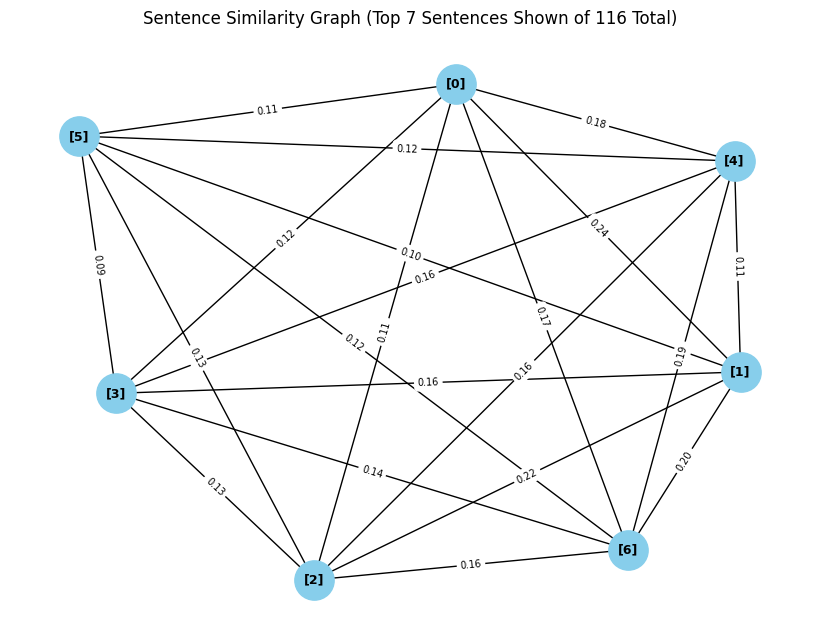

In [139]:
# load text
file_path = 'Missive_001_CleanedByHand.txt'
with open(file_path, 'r', encoding='utf-8') as file:
    missive_text = file.read()

# run LexRank summarization
num_sentences_to_extract = 10
summary = lexrank_summarize(missive_text, num_sentences=num_sentences_to_extract)

# recompute similarity matrix just for the summary sentences
tokens_list = [tokenize(sentence) for sentence in summary]
tf = compute_tf(tokens_list)
idf = compute_idf(tokens_list)
tfidf_vectors = compute_tfidf(tf, idf)
sim_matrix = cosine_sim_matrix(tfidf_vectors)

# visualize summary graph
total_sent_count = len(split_sentences(missive_text)) 

visualize_sentence_graph(
    sentences=summary,
    sim_matrix=sim_matrix,
    total_sentences=total_sent_count,
    num_nodes=7,
    threshold=0.1,
    force_edges=True
)

## **Part 1.2: LexRank output inspection for "Missive_001" in "GaLAHaD_missive_partially_translated.csv"**

The output only inspects the data of the first text of "GaLAHaD_missive_partially_translated.csv", but this can be altered by changing the "file_path" variable. 

**1:** The first cell inspects the output as is.  <br>
**2:** The second cell inspects the output as a graph based model by also visualizing the actual methodology

In [140]:
# Parameters
num_sentences_to_extract = 10
file_path = 'Missive_001_CleanedByHand.txt'
csv_path = 'GaLAHaD_missive_partial_translation.csv'

# Part 1: Summarize the cleaned hand-transcribed TXT file
print(f"\nLexRank Summary from: {file_path}\n{'-' * 50}")

with open(file_path, 'r', encoding='utf-8') as file:
    missive_text = file.read()

summary_txt = lexrank_summarize(missive_text, num_sentences=num_sentences_to_extract)

print(f"\nTop {num_sentences_to_extract} Topic Sentences (from TXT):\n")
for i, sentence in enumerate(summary_txt, 1):
    print(f"{i}. {sentence}")

# Part 2: Summarize the first entry in the GaLAHaD CSV file
print(f"\nLexRank Summary from: {csv_path} (first record)\n{'-' * 50}")

df = pd.read_csv(csv_path)

if 'text' not in df.columns:
    raise ValueError(f"The file '{csv_path}' must contain a 'text' column.")

first_text = str(df.loc[0, 'text'])

summary_csv = lexrank_summarize(first_text, num_sentences=num_sentences_to_extract)

print(f"\nTop {num_sentences_to_extract} Topic Sentences (from CSV):\n")
for i, sentence in enumerate(summary_csv, 1):
    print(f"{i}. {sentence}")




LexRank Summary from: Missive_001_CleanedByHand.txt
--------------------------------------------------

Top 10 Topic Sentences (from TXT):

1. Dan het schijnen dat zulks beteren voor eerst nog niet te wehen zullen kunnen worden brengen en dat vermits Uwe Edele nu enig jaar achter de ander zo sober equiperen en zo weinig schepen zenden hebben
2. Zo hopen dat met de goed schours die toekomend jaar van Uwe Edele te verwachten hebben, zij alsdan met geweld Moluger, Amboijna en Banda wel weren en verdrijven zullen
3. Maar alzo het verdrag met de Makassaar de Compagnie doen te veel schadelijk in Amboijna en Banda wezen zullen door de vrij vaart en handel welk de Makassaar in die kwartier zullen pretenderen te doen
4. En dat dievolg en bereid zijn te gaan of blijven daar de Generaal Compagnie e van ik goed dikken worden van
5. Maar zijn arresteren na naar gebruiken ten du woor en ne de s een document dat voor eerst nog blijven zullen en ons voorder naar gelegenheid van zaak en de tijd regule


Sentences used in graph:
[0] hebben wij het opgehen na+de tijding van+de moluguis en daar naar om dat de timmerlieden van+het zelvig voor zijn vertrek het jacht de zuider Eendracht wat verzien houden
[1] daar tegen appar zijn de+Engelsen een goed macht bij de ander bekomen zullen zo zijn+het
[2] hebben ook de tijd niet om op zijn Spaans water bak te maken toen ons schepen en Manilla zijn
[3] een groot dienstje scheiden en zullen alwaren+het ook dat de prijs van+de nagelen zullen moeten verhogen
[4] dan zijn beide in+de Moluquis hebben en dat oog zeggen worden vermits de ternataar enig nieuwigheid varen hebben
[5] met enig provisie en een goed som veld om de+Engelsen te preveniëren en al de nagel
[6] die tegens hebben het goed schip van de Engelsen


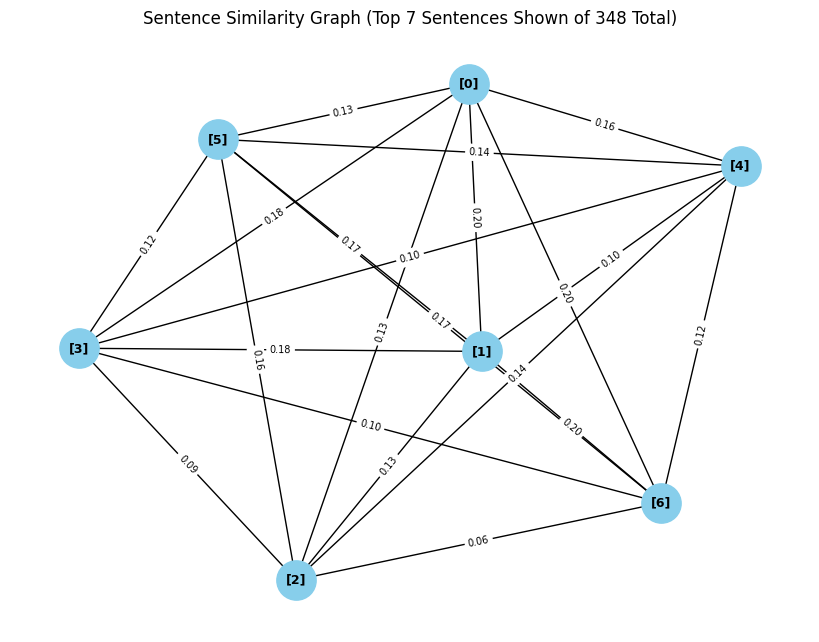

In [141]:
csv_path = 'GaLAHaD_missive_partial_translation.csv'

# Load CSV
df = pd.read_csv(csv_path, encoding='utf-8')

# Automatically use the 'text' column (since you confirmed it exists)
if 'text' not in df.columns:
    raise ValueError("CSV does not contain a 'text' column.")

# Example: process the first missive only
missive_text = df.loc[0, 'text']

# Number of sentences to extract in summary
num_sentences_to_extract = 10

# Run LexRank summarization
summary = lexrank_summarize(missive_text, num_sentences=num_sentences_to_extract)

# Recompute similarity matrix just for summary sentences
tokens_list = [tokenize(sentence) for sentence in summary]
tf = compute_tf(tokens_list)
idf = compute_idf(tokens_list)
tfidf_vectors = compute_tfidf(tf, idf)
sim_matrix = cosine_sim_matrix(tfidf_vectors)

# Total sentences in the original missive text
total_sent_count = len(split_sentences(missive_text))

# Visualize summary graph
visualize_sentence_graph(
    sentences=summary,
    sim_matrix=sim_matrix,
    total_sentences=total_sent_count,
    num_nodes=7,
    threshold=0.1,
    force_edges=True
)

# **Part 2: BM25**

### **Part 2.1: Actual BM25 code used for Visualization**

In [152]:
def tokenize(text):
    return text.lower().split()

class BM25:
    def __init__(self, corpus, k1=1.5, b=0.75):
        self.k1 = k1
        self.b = b
        self.corpus = [tokenize(doc) for doc in corpus]
        self.doc_len = [len(doc) for doc in self.corpus]
        self.avgdl = np.mean(self.doc_len) if self.doc_len else 0
        self.df = {}
        self.idf = {}
        self.N = len(self.corpus)
        self.build()

    def build(self):
        for doc in self.corpus:
            seen = set()
            for word in doc:
                if word not in seen:
                    self.df[word] = self.df.get(word, 0) + 1
                    seen.add(word)
        for word, freq in self.df.items():
            self.idf[word] = math.log(1 + (self.N - freq + 0.5) / (freq + 0.5))

    def score(self, query, index):
        score = 0.0
        doc = self.corpus[index]
        freq = Counter(doc)
        dl = len(doc)
        for word in tokenize(query):
            if word in self.idf:
                f = freq.get(word, 0)
                idf = self.idf[word]
                denom = f + self.k1 * (1 - self.b + self.b * dl / self.avgdl) if self.avgdl > 0 else 1
                score += idf * (f * (self.k1 + 1)) / denom
        return score

    def get_scores(self, query):
        return [self.score(query, i) for i in range(self.N)]

def match_lexrank_sentences_to_documents_topk(summary_sentences, dfs, filenames, top_k=3):
    """
    For each summary sentence, find the top_k documents (across all dfs) with highest BM25 scores.
    Return a list of lists: for each sentence, a list of tuples (score, df_index, text, filename, row_index).
    """
    results = []

    for sentence in summary_sentences:
        candidates = []

        for df, fname in zip(dfs, filenames):
            bm25 = BM25(df['text'].tolist())
            scores = bm25.get_scores(sentence)
            for idx, score in enumerate(scores):
                candidates.append((score, idx, df.iloc[idx]['text'], fname))

        # Sort candidates by score descending, keep top_k
        top_candidates = sorted(candidates, key=lambda x: x[0], reverse=True)[:top_k]
        # Format result for this sentence: (score, doc_index, text snippet, file, row_index)
        # Here doc_index == row_index within that file's df
        results.append(top_candidates)

    return results

### **Part 2.2: BM25 for Output inspection**

In [143]:
# Control how many top documents to retrieve per sentence
top_k_bm25 = 3

# Load both versions of the missive
missive_csv_path = 'GaLAHaD_missive_partial_translation.csv'
cleaned_missive_path = 'Missive_001_CleanedByHand.txt'

df_generale_missive = pd.read_csv(missive_csv_path)
csv_text = str(df_generale_missive.loc[0, 'text'])

with open(cleaned_missive_path, 'r', encoding='utf-8') as f:
    cleaned_text = f.read()

# LexRank summarization
num_sentences_to_extract = 3
summary_csv = lexrank_summarize(csv_text, num_sentences=num_sentences_to_extract)
summary_cleaned = lexrank_summarize(cleaned_text, num_sentences=num_sentences_to_extract)

# Load corpora for matching
transcriptions_folder = 'transcriptions_sorted'
missive_year = int(df_generale_missive.loc[0, 'year'])
target_years = [missive_year - i for i in range(3)]
target_files = [os.path.join(transcriptions_folder, f"{year}.csv") for year in target_years]

dfs = []
loaded_files = []
for file_path in target_files:
    if os.path.exists(file_path):
        df = pd.read_csv(file_path)
        if 'content' in df.columns:
            df = df.rename(columns={'content': 'text'})
        df['text'] = df['text'].astype(str)
        dfs.append(df)
        loaded_files.append(os.path.basename(file_path))
    else:
        print(f"Warning: {file_path} not found. Skipping.")

# Tokenizer and BM25 class used for inspection only
def tokenize(text):
    return text.lower().split()

class BM25:
    def __init__(self, corpus, k1=1.5, b=0.75):
        self.k1 = k1
        self.b = b
        self.corpus = [tokenize(doc) for doc in corpus]
        self.doc_len = [len(doc) for doc in self.corpus]
        self.avgdl = np.mean(self.doc_len) if self.doc_len else 0
        self.df = {}
        self.idf = {}
        self.N = len(self.corpus)
        self.build()

    def build(self):
        for doc in self.corpus:
            seen = set()
            for word in doc:
                if word not in seen:
                    self.df[word] = self.df.get(word, 0) + 1
                    seen.add(word)
        for word, freq in self.df.items():
            self.idf[word] = math.log(1 + (self.N - freq + 0.5) / (freq + 0.5))

    def score(self, query, index):
        score = 0.0
        doc = self.corpus[index]
        freq = Counter(doc)
        dl = len(doc)
        for word in tokenize(query):
            if word in self.idf:
                f = freq.get(word, 0)
                idf = self.idf[word]
                denom = f + self.k1 * (1 - self.b + self.b * dl / self.avgdl) if self.avgdl > 0 else 1
                score += idf * (f * (self.k1 + 1)) / denom
        return score

    def get_scores(self, query):
        return [self.score(query, i) for i in range(self.N)]

def match_lexrank_sentences_to_documents_topk(summary_sentences, dfs, filenames, top_k=3):
    results = []
    for sentence in summary_sentences:
        candidates = []
        for df, fname in zip(dfs, filenames):
            bm25 = BM25(df['text'].tolist())
            scores = bm25.get_scores(sentence)
            for idx, score in enumerate(scores):
                candidates.append((score, idx, df.iloc[idx]['text'], fname))
        top_candidates = sorted(candidates, key=lambda x: x[0], reverse=True)[:top_k]
        results.append(top_candidates)
    return results

# Run matching for both versions
print("\nMatching for CSV Missive (GaLAHaD translation)")
matches_csv = match_lexrank_sentences_to_documents_topk(summary_csv, dfs, loaded_files, top_k=top_k_bm25)
for i, top_docs in enumerate(matches_csv):
    print(f"\nSentence {i+1}: {summary_csv[i]}")
    for score, idx, text, fname in top_docs:
        snippet = ' '.join(text.split()[:20]) + "..."
        print(f"  Score: {score:.4f} | File: {fname} | Row: {idx} | Snippet: {snippet}")

print("\nMatching for Cleaned Missive")
matches_cleaned = match_lexrank_sentences_to_documents_topk(summary_cleaned, dfs, loaded_files, top_k=top_k_bm25)
for i, top_docs in enumerate(matches_cleaned):
    print(f"\nSentence {i+1}: {summary_cleaned[i]}")
    for score, idx, text, fname in top_docs:
        snippet = ' '.join(text.split()[:20]) + "..."
        print(f"  Score: {score:.4f} | File: {fname} | Row: {idx} | Snippet: {snippet}")



Matching for CSV Missive (GaLAHaD translation)

Sentence 1: hebben ook de tijd niet om op zijn Spaans water bak te maken toen ons schepen en Manilla zijn
  Score: 17.4949 | File: 1616.csv | Row: 54 | Snippet: wederomme naert Vaderlandt te keeren versocht heeft mette eerste schepen dewwaerts te mogen gaen en gemerckt zij hooge maentgelee heeft...
  Score: 16.2798 | File: 1617.csv | Row: 158 | Snippet: Gnal Reaels Brieff uyt Banda vanden 10en Mayo Ao. 1617 a folio Ditto Inal Reaels brieff van Amboyno vanden 2en...
  Score: 14.5188 | File: 1617.csv | Row: 25 | Snippet: Erentfeste wijse. voorsielkihe heer discrete Heeren. ok hebbe (:volgens mijne schuldige plicht :) niet connen nalaten. V. Ed: met dese...

Sentence 2: zullen de tijd aanzien en naar loop van zaak disponeren het zijn zeggen
  Score: 12.8752 | File: 1616.csv | Row: 133 | Snippet: Arnmo Junj 1616 No. 6 Journael vande dagelycxse geschiedenisse ende moluco Gedt. 3 Julio 1655 to S XVNS onder Ambogna...
  Score: 12.6567 | File: 1

# **Part 3: Graph-Based Visualization**

In [155]:
def visualize_interactive_graph(missive_name, top_sentences, similarity_scores, doc_metadata, doc_snippets, meta, num_top_docs=3):
    G = nx.DiGraph()

    # Main Missive node hover multiline
    missive_hover = (
        f"Filename: {meta.get('filename', 'N/A')}<br>"
        f"Source: {meta.get('source', 'N/A')}<br>"
        f"Year: {meta.get('year', 'N/A')}"
    )
    G.add_node("M", label="M", hover=missive_hover, group='missive')

    positions = {"M": (0, 0)}
    y_spacing = -2
    x_spacing = 3
    doc_y_base = y_spacing * 2
    doc_y_spacing = 1.5

    for i, sentence in enumerate(top_sentences):
        sent_node = f"S{i+1}"
        sent_x = (i - (len(top_sentences) - 1) / 2) * x_spacing
        sent_y = y_spacing
        sent_hover = f"{sentence}<br>Topic sentence #{i+1}"
        positions[sent_node] = (sent_x, sent_y)
        G.add_node(sent_node, label=sent_node, hover=sent_hover, group='sentence')
        G.add_edge("M", sent_node)

        for j in range(num_top_docs):
            doc_index = i * num_top_docs + j
            if doc_index >= len(doc_metadata):
                continue
            csv_file, row_index = doc_metadata[doc_index]
            score = similarity_scores[i][j]
            snippet = doc_snippets[doc_index]
            snippet_preview = (snippet[:150] + "...") if len(snippet) > 150 else snippet
            doc_label = f"{i+1}{chr(65+j)}"
            doc_hover = (
                f"Document: {csv_file} - Row {row_index}<br>"
                f"BM25 score: {score:.4f}<br>"
                f"Text snippet:<br>{snippet_preview}"
            )
            doc_x = sent_x + (j - (num_top_docs - 1) / 2) * 1.5
            doc_y = doc_y_base - i * doc_y_spacing
            positions[doc_label] = (doc_x, doc_y)
            G.add_node(doc_label, label=doc_label, hover=doc_hover, group='document')
            G.add_edge(sent_node, doc_label)

    # Edges
    edge_x, edge_y = [], []
    for src, tgt in G.edges():
        x0, y0 = positions[src]
        x1, y1 = positions[tgt]
        edge_x += [x0, x1, None]
        edge_y += [y0, y1, None]

    edge_trace = go.Scatter(
        x=edge_x, y=edge_y,
        line=dict(width=1.5, color='#888'),
        hoverinfo='none',
        mode='lines'
    )

    # Nodes
    node_x, node_y, node_text, node_hover, node_color, node_textpos = [], [], [], [], [], []
    color_map = {'missive': 'skyblue', 'sentence': 'lightgreen', 'document': 'lightcoral'}

    for node, attrs in G.nodes(data=True):
        x, y = positions[node]
        node_x.append(x)
        node_y.append(y)
        node_hover.append(attrs['hover'])
        node_color.append(color_map[attrs['group']])
        node_text.append(attrs['label'])
        node_textpos.append('middle center')

    node_trace = go.Scatter(
        x=node_x, y=node_y,
        mode='markers+text',
        text=node_text,
        textposition=node_textpos,
        hovertext=node_hover,
        hoverinfo='text',
        marker=dict(size=30, color=node_color, line=dict(width=2)),
        textfont=dict(size=14, color='black', family='Arial Black')
    )

    # Legend
    legend_items = [
        ("skyblue", "M = Missive"),
        ("lightgreen", "S1, S2... = Top Sentences"),
        ("lightcoral", "1A, 2B... = Source Docs")
    ]
    legend_shapes = []
    legend_annotations = []
    rect_x0, rect_x1 = 0.02, 0.05
    text_x = 0.06
    rect_height = 0.05

    for i, (color, label) in enumerate(legend_items):
        y_pos = 1.0 - i * 0.07
        legend_shapes.append(dict(
            type="rect",
            x0=rect_x0, y0=y_pos, x1=rect_x1, y1=y_pos + rect_height,
            xref="paper", yref="paper",
            fillcolor=color, line=dict(width=1)
        ))
        legend_annotations.append(dict(
            x=text_x, 
            y=y_pos + rect_height / 2 + 0.01,
            xref="paper", 
            yref="paper",
            text=label,
            showarrow=False,
            align="left",
            font=dict(size=12, family='Arial'),
            yanchor="middle"
        ))

    fig = go.Figure(
        data=[edge_trace, node_trace],
        layout=go.Layout(
            title=dict(text='Missive Similarity Graph (BM25)', x=0.5, font=dict(size=16)),
            showlegend=False,
            hovermode='closest',
            margin=dict(b=20, l=120, r=20, t=60),
            xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
            yaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
            shapes=legend_shapes,
            annotations=legend_annotations
        )
    )

    fig.show()

def print_graph_legend(top_sentences, similarity_scores, doc_metadata, num_top_docs):
    print("\nGraph Node Legend:\n")
    for i, sentence in enumerate(top_sentences):
        print(f"S{i+1}: {sentence}")
        for j in range(num_top_docs):
            node_label = f"{i+1}{chr(ord('A') + j)}"
            score = similarity_scores[i][j]
            filename, row_index = doc_metadata[i * num_top_docs + j]
            print(f"  {node_label}: BM25 Score = {score:.4f}, Document = {filename} (Row {row_index})")
        print()


### **Part 3.1: Execute the cell below to generate the interactive visualization of missive similarities**

Average runtime for 3 topic sentences and 3 similar documents is: `60 seconds`?

Enter the row index of the missive [Value Range: 1-923]:  1
Enter the number of topic sentences to extract [Recommended: 2-10]:  3
Enter the number of similar documents per sentence [Recommended: 1-5]:  3



Total missives in file: 923
Total transcription documents loaded: 503

Processing missive from row 1 (missive_001):

BM25 model loaded texts from:
  - 1616.csv
  - 1617.csv
  - 1618.csv



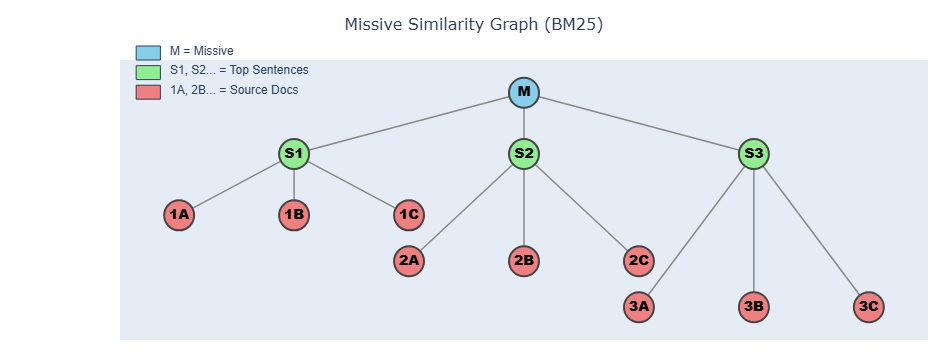


Graph Node Legend:

S1: hebben ook de tijd niet om op zijn Spaans water bak te maken toen ons schepen en Manilla zijn
  1A: BM25 Score = 17.4949, Document = 1616.csv (Row 54)
  1B: BM25 Score = 16.2798, Document = 1617.csv (Row 158)
  1C: BM25 Score = 14.5188, Document = 1617.csv (Row 25)

S2: zullen de tijd aanzien en naar loop van zaak disponeren het zijn zeggen
  2A: BM25 Score = 12.8752, Document = 1616.csv (Row 133)
  2B: BM25 Score = 12.6567, Document = 1618.csv (Row 5)
  2C: BM25 Score = 10.7530, Document = 1616.csv (Row 90)

S3: met enig provisie en een goed som veld om de+Engelsen te preveniëren en al de nagel
  3A: BM25 Score = 10.7715, Document = 1618.csv (Row 9)
  3B: BM25 Score = 10.0784, Document = 1617.csv (Row 65)
  3C: BM25 Score = 9.5313, Document = 1618.csv (Row 48)



In [156]:
# User input and validation
df_missives = pd.read_csv('GaLAHaD_missive_partial_translation.csv')
total_missives = len(df_missives)

try:
    missive_index_user = int(input(f"Enter the row index of the missive [Value Range: 1-{total_missives}]: "))
    if not (1 <= missive_index_user <= total_missives):
        raise ValueError(f"Missive index must be between 1 and {total_missives} (inclusive).")
    missive_index = missive_index_user - 1  # zero-based internally

    num_top_sentences = int(input("Enter the number of topic sentences to extract [Recommended: 2-10]: "))
    if not (2 <= num_top_sentences <= 10):
        raise ValueError("Number of topic sentences should be between 2 and 10.")

    num_top_sim_docs = int(input("Enter the number of similar documents per sentence [Recommended: 1-5]: "))
    if not (1 <= num_top_sim_docs <= 5):
        raise ValueError("Number of similar documents per sentence should be between 1 and 5.")

except ValueError as ve:
    print(f"Invalid input: {ve}")
    raise SystemExit

# Load selected missive metadata and text
meta = df_missives.loc[missive_index]
missive_text = meta['text']
missive_year = int(meta['year'])
start_year = missive_year - 2
end_year = missive_year

# Format missive filename for display
missive_filename = f"missive_{missive_index_user:03d}"

# Load transcription documents from years in range
dfs = []
loaded_files = []

for year in range(start_year, end_year + 1):
    path = os.path.join('transcriptions_sorted', f"{year}.csv")
    if os.path.exists(path):
        df = pd.read_csv(path)
        if 'content' in df.columns:
            df = df.rename(columns={'content': 'text'})
        df['text'] = df['text'].astype(str)
        dfs.append(df)
        loaded_files.append(os.path.basename(path))
    else:
        print(f"Warning: {path} not found. Skipping.")

# Summarize missive text
summary = lexrank_summarize(missive_text, num_sentences=num_top_sentences)

# Run BM25 matching for top K docs per sentence
matches = match_lexrank_sentences_to_documents_topk(summary, dfs, loaded_files, top_k=num_top_sim_docs)

# Prepare outputs for visualization
top_sentences = summary
similarity_scores = []
doc_metadata = []
doc_snippets = []

for sentence_matches in matches:
    scores = []
    docs = []
    snippets = []
    for score, row_index, text, filename in sentence_matches:
        scores.append(score)
        docs.append((filename, row_index))
        snippet = ' '.join(text.split()[:30])  # first 30 words snippet
        snippets.append(snippet)
    similarity_scores.append(scores)
    doc_metadata.extend(docs)
    doc_snippets.extend(snippets)

print(f"\nTotal missives in file: {total_missives}")
print(f"Total transcription documents loaded: {sum(len(df) for df in dfs)}\n")

print(f"Processing missive from row {missive_index_user} ({missive_filename}):\n")

print("BM25 model loaded texts from:")
for fname in loaded_files:
    print(f"  - {fname}")
print()

visualize_interactive_graph(
   missive_name=missive_filename,
   top_sentences=top_sentences,
   similarity_scores=similarity_scores,
   doc_metadata=doc_metadata,
   doc_snippets=doc_snippets,
   meta=meta,
   num_top_docs=num_top_sim_docs
)

# print the legend after the graph
print_graph_legend(top_sentences, similarity_scores, doc_metadata, num_top_sim_docs)

### **Part 3.2: Helper function for printing the text/content of a specific letter**

In [148]:
def print_single_doc_text():
    print("Enter the year of the CSV file (e.g., 1616):")
    year_input = input().strip()
    filename = f"{year_input}.csv"
    
    print("Enter the row index in that CSV (e.g., 133):")
    try:
        row_index = int(input().strip())
    except ValueError:
        print("Invalid row index. Please enter an integer.")
        return
    
    filepath = os.path.join('transcriptions_sorted', filename)
    if not os.path.exists(filepath):
        print(f"File not found: {filepath}")
        return
    
    df = pd.read_csv(filepath)
    if 'content' not in df.columns:
        print(f"'content' column not found in {filename}")
        return
    
    if row_index < 0 or row_index >= len(df):
        print(f"Row index {row_index} out of range for file {filename} (0 to {len(df)-1})")
        return
    
    text = df.loc[row_index, 'content']
    print(f"\nText from {filename} at row {row_index}:\n")
    print(text)

# Call the function to run interactively
print_single_doc_text()


Enter the year of the CSV file (e.g., 1616):


 1618


Enter the row index in that CSV (e.g., 133):


 5



Text from 1618.csv at row 5:

Copie.
Voor d'Ed: Heer President. den tehenwoordigen taedt voorgedragen zijnde.
seeckeren brieff. vande Francen ontfangen der Schepen St. Michiel. e
St. Louijs. te St. Malo, uijtgerust. gedateert 11. deser. Waer bij.
Sijn versoeckende. ontslaginge vant' gearresteerde Schip St. Michiel.
presenterende ons getuijchnisse van seeckere Javanen te brengen.
dien hans de decker. hunnen Escherael. hebben gebracht. 15. oft
20. mijlen In Zee aen een vande Engelse Schepen: vertrocken den lesten
Januario Passado. Ten anderen mede gelesen zijnde. sijnde
seekere attestatie In date 19. februario Passado. bij Jan Mertijnsz.
Constapel. ende Francoijs Pietersz Cuijper. uijtgevaren opt'
schip St. Louijs. ende alhier. daer van gelicht. Waer bij verclaren.
dat tot verscheijden tijden: vanden Admirael Sr. Michiel. de Prince
vlagge. vande grote stenge heeft gewacht. Ende onder de—
selve eenige Souseratse moorse. ende andere Schepen vervolcht
ende aengehaelt hebben. Waer over bij 